In [4]:
import numpy as np
import pandas as pd
import warnings
import os

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.compat.v1.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D

warnings.simplefilter('ignore')

countryName = 'Brazil'

nFeatures = 1

nDaysMin = 10
k = 7

nValid = 10
nTest = 10

In [5]:
dataDir = os.path.join('C:\\Users\\AMC\\Desktop\\Roshi\\Data')
confirmedFilename = 'confirmed_july.csv'
deathsFilename = 'deaths_july.csv'
recoveredFilename = 'recovered_july.csv'

In [6]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, k):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix + k >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+k]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
def meanAbsolutePercentageError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    absPcErrorList = [absError/yTrue for absError, yTrue in zip(absErrorList, yTrueList)]
    MAPE = 100*np.mean(absPcErrorList)
    return MAPE

def meanAbsolutePercentageError_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
            
    # Get MAPE for each day in a list
    MAPEList = []
    for i in yTrueForDayK.keys():
        MAPEList.append(meanAbsolutePercentageError(yTrueForDayK[i], yPredForDayK[i]))
    return np.mean(MAPEList)

def meanForecastError(yTrueList, yPredList):
    forecastErrors = [yTrue - yPred for yTrue, yPred in zip(yTrueList, yPredList)]
    MFE = np.mean(forecastErrors)
    return MFE

def meanAbsoluteError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(absErrorList)

def meanSquaredError(yTrueList, yPredList):
    sqErrorList = [np.square(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(sqErrorList)

def rootMeanSquaredError(yTrueList, yPredList):
    return np.sqrt(meanSquaredError(yTrueList, yPredList))
def medianSymmetricAccuracy(yTrueList, yPredList):
    '''https://helda.helsinki.fi//bitstream/handle/10138/312261/2017SW001669.pdf?sequence=1'''
    logAccRatioList = [np.abs(np.log(yPred/yTrue)) for yTrue, yPred in zip(yTrueList, yPredList)]
    MdSA = 100*(np.exp(np.median(logAccRatioList))-1)
    return MdSA

def medianSymmetricAccuracy_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
    # Get MdSA for each day in a list
    MdSAList = []
    for i in yTrueForDayK.keys():
        MdSAList.append(medianSymmetricAccuracy(yTrueForDayK[i], yPredForDayK[i]))
    return(np.mean(MdSAList))

In [8]:
# Get all the frames for a country
def getCountryCovidFrDict(countryName):
    countryCovidFrDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryCovidFrDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryCovidFrDict

In [9]:
# Load all 3 csv files
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(confirmedFilename)
covidFrDict['deaths'] = pd.read_csv(deathsFilename)
covidFrDict['recovered'] = pd.read_csv(recoveredFilename)

countryCovidFrDict = getCountryCovidFrDict(countryName)

# List of dates
colNamesList = list(countryCovidFrDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName]
dataList = [countryCovidFrDict['confirmed'][date].iloc[0] for date in dateList]
dataDict = dict(zip(dateList, dataList))

# Only take time series from where the cases were >100
daysSince = 100
nCasesGreaterDaysSinceList = []
datesGreaterDaysSinceList = []

for key in dataDict.keys():
    if dataDict[key] > daysSince:
        datesGreaterDaysSinceList.append(key)
        nCasesGreaterDaysSinceList.append(dataDict[key])
        
XList, yList = split_sequence(nCasesGreaterDaysSinceList, nDaysMin, k)

XTrainList = XList[0:len(XList)-(nValid + nTest)]
XValidList = XList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
XTestList = XList[-nTest:]

yTrain = yList[0:len(XList)-(nValid + nTest)]
yValid = yList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
yTest = yList[-nTest:]
print('Total size of data points for LSTM:', len(yList))
print('Size of training set:', len(yTrain))
print('Size of validation set:', len(yValid))
print('Size of test set:', len(yTest))

# Convert the list to matrix
XTrain = XTrainList.reshape((XTrainList.shape[0], XTrainList.shape[1], nFeatures))
XValid = XValidList.reshape((XValidList.shape[0], XValidList.shape[1], nFeatures))
XTest = XTestList.reshape((XTestList.shape[0], XTestList.shape[1], nFeatures))

Total size of data points for LSTM: 121
Size of training set: 101
Size of validation set: 10
Size of test set: 10


# Vanilla LSTM

In [10]:
nNeurons = 100 # number of neurones
nFeatures = 1  # number of features

bestValidMAPE = 100 # 100 validation for best MAPE
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    
    # define model
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)
    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')
model.summary()

# fit model
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 8.69604090672853
Updating best MAPE to 8.69604090672853...
Updating best seed to 0...
1 14.361459568269979
2 99.98467095751134
3 9.08490209723389
4 21.58424845199713
5 8.337532515955404
Updating best MAPE to 8.337532515955404...
Updating best seed to 5...
6 99.97910916254845
7 0.8632776547918172
Updating best MAPE to 0.8632776547918172...
Updating best seed to 7...
8 5.731401984382951
9 13.532425277823725
10 nan
11 7.860265288121986
12 99.97842431083222
13 99.98258263230117
14 6.174146350587541
15 99.99657506561032
16 7.2448004485321595
17 4.4892307690043385
18 2.027390823212955
19 10.601387720072864
20 12.942244785050658
21 20.727766578734457
22 7.844085782202526
23 14.4433828697482
24 3.7791541879141737
25 99.9864929677732
26 99.99633250406602
27 4.234638234384858
28 99.98696482646633
29 10.92828250974578
30 17.22229412404289
31 99.9816984536724
32 99.98058691561714
33 1.733020344795175
34 3.831056277274316
35 1.6895950066856227
36 99.99217393645453
37 8.250839489412366
38 0.952238

In [ ]:
yPred


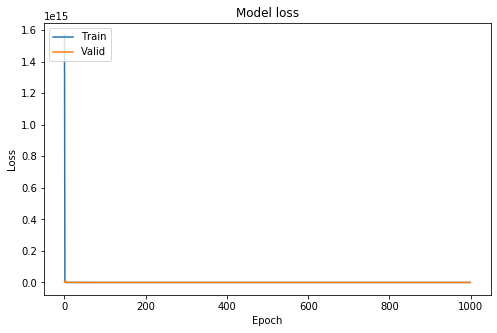

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [12]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)

yPredVanilla = yPredListList    
#Test MAPE: 1.6745435735052931
#Test MdSA: 1.704668241474819
#Test MSE: 1824907959.341518
#Test RMSE: 42718.94145857921

Test MAPE: 1.6745435735052931
Test MdSA: 1.704668241474819
Test MSE: 1824907959.341518
Test RMSE: 42718.94145857921


In [ ]:
from sklearn.metrics import mean_squared_error
#mean_squared_error = mean(forecast_error^2)
mse = mean_squared_error(yTest[-1], yPredVanilla[-1])
print('MSE: %f' % mse)
#RMSE = rootMeanSquaredError(yTest[-1], yPredListList)
#print('Test RMSE:', RMSE)

In [ ]:
yTest[-1]

In [ ]:
yPredVanilla[-1]

# Stacked LSTM

In [13]:
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
    model.add(LSTM(nNeurons, activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)
        
        
#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)

    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
        
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
model.add(LSTM(nNeurons, activation='relu'))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 74.55014037465766
Updating best MAPE to 74.55014037465766...
Updating best seed to 0...
1 99.97349348837291
2 112.45564794063151
3 10.970222571163248
Updating best MAPE to 10.970222571163248...
Updating best seed to 3...
4 7.818005550498824
Updating best MAPE to 7.818005550498824...
Updating best seed to 4...
5 336.5925413321224
6 463.3221472730114
7 5.398606686101666
Updating best MAPE to 5.398606686101666...
Updating best seed to 7...
8 99.97908218394066
9 nan
10 nan
11 134.5012617466229
12 99.97902591263862
13 80.75214531361918
14 99.99764535643817
15 99.99571670139582
16 75.3623376095156
17 80.4991333150635
18 265466.6246299998
19 6.63534285031614
20 8.701556859687875
21 77.52789380743833
22 99.97945791184279
23 99.98872706136191
24 2.1484314369641746
Updating best MAPE to 2.1484314369641746...
Updating best seed to 24...
25 99.98814037371265
26 80.56688682628736
27 9.764709653766005
28 1.559605509124893
Updating best MAPE to 1.559605509124893...
Updating best seed to 28...
29 13

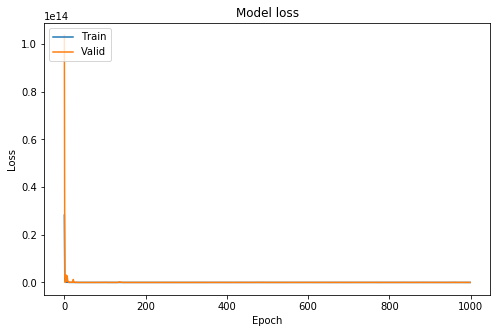

In [14]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [15]:
# fit model
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=1)


Epoch 1/1000
4/4 [==============================] - 0s 57ms/step - loss: 42959760.0000 - val_loss: 18353319936.0000
Epoch 2/1000
4/4 [==============================] - 0s 56ms/step - loss: 75072984.0000 - val_loss: 9287603200.0000
Epoch 3/1000
4/4 [==============================] - 0s 54ms/step - loss: 135199808.0000 - val_loss: 29676236800.0000
Epoch 4/1000
4/4 [==============================] - 0s 62ms/step - loss: 185372544.0000 - val_loss: 5625703424.0000
Epoch 5/1000
4/4 [==============================] - 0s 53ms/step - loss: 575409664.0000 - val_loss: 35861618688.0000
Epoch 6/1000
4/4 [==============================] - 0s 55ms/step - loss: 328913088.0000 - val_loss: 17891633152.0000
Epoch 7/1000
4/4 [==============================] - 0s 46ms/step - loss: 354765600.0000 - val_loss: 8492974080.0000
Epoch 8/1000
4/4 [==============================] - 0s 50ms/step - loss: 206240496.0000 - val_loss: 29905473536.0000
Epoch 9/1000
4/4 [==============================] - 0s 59ms/step - lo

In [17]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredStacked = yPredListList
#Test MAPE: 1.4535842923254318
#Test MdSA: 1.4623509287121195
#Test MSE: 1421445505.5616071
#Test RMSE: 37702.06235156914

Test MAPE: 10.56921048597825
Test MdSA: 10.084669140631272
Test MSE: 53390588843.196205
Test RMSE: 231064.03623929925


# Bi-directional LSTM

In [18]:
# define model
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 99.9840956617543
Updating best MAPE to 99.9840956617543...
Updating best seed to 0...
1 7.360001056734823
Updating best MAPE to 7.360001056734823...
Updating best seed to 1...
2 16.1774911816413
3 10.131755715186111
4 99.98184492754396
5 13.11544241095612
6 6.14329969851817
Updating best MAPE to 6.14329969851817...
Updating best seed to 6...
7 5.037730331195683
Updating best MAPE to 5.037730331195683...
Updating best seed to 7...
8 99.98387838723794
9 3.5873348013924713
Updating best MAPE to 3.5873348013924713...
Updating best seed to 9...
10 6.771833000381046
11 3.984985455382821
12 11.823809559094816
13 1114908261104.5432
14 274101308191.95773
15 5.255919389162611
16 5.132468436334221
17 99.9898379554598
18 4.2296915756249165
19 6.789993865364252
20 14.5082734962708
21 99.98283913881642
22 9.250625271538297
23 5.094161766283229
24 4.898006719825851
25 99.97993580622804
26 10.633797309305569
27 4.985006728368268
28 3.2007613118389022
Updating best MAPE to 3.2007613118389022...
Updat

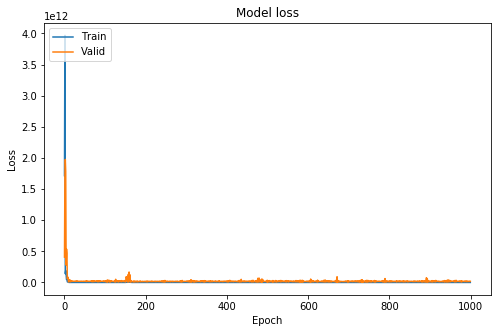

In [19]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [20]:
from matplotlib import pyplot

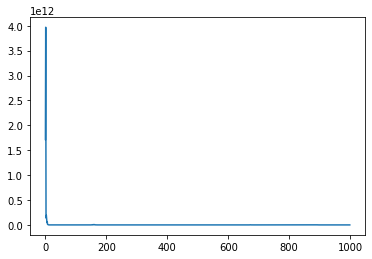

In [21]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.show()

In [22]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredBidirectional = yPredListList
#Test MAPE: 2.100402594194455
#Test MdSA: 1.7000446736904482
#Test MSE: 4952869697.534375
#Test RMSE: 70376.62749474696

Test MAPE: 2.100402594194455
Test MdSA: 1.7000446736904482
Test MSE: 4952869697.534375
Test RMSE: 70376.62749474696


In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Format y tick labels
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

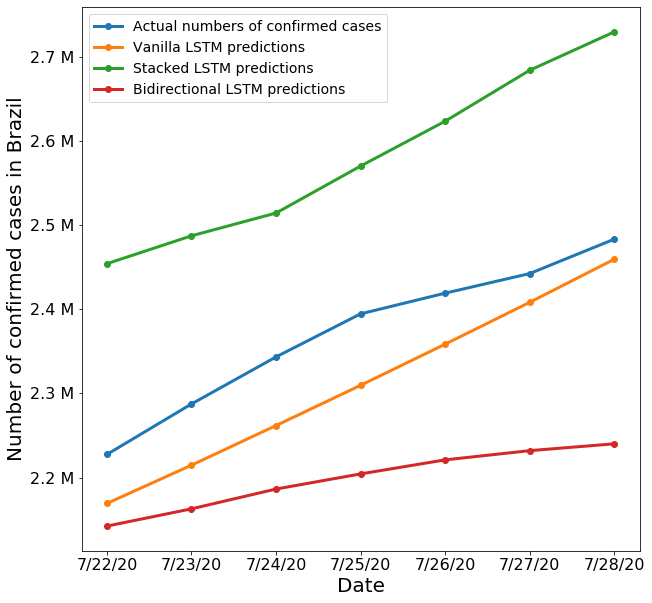

In [24]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in Brazil', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
plt.savefig(os.path.join('Plots_10days_k7', 'predictions_{}.png'.format(countryName)), dpi=400)
plt.savefig(os.path.join('Plots_10days_k7', 'predictions_{}.pdf'.format(countryName)), dpi=400)

In [25]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla)
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked)
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional)
print('Test RMSE:', RMSE)

Test RMSE: 274065.0072636376
Test RMSE: 132586.71920364388
Test RMSE: 328633.1670366348


In [26]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional[-1])
print('Test RMSE:', RMSE)
#Test RMSE: 63165.99174545983
#Test RMSE: 211104.74184071264
#Test RMSE: 179717.17669540123

Test RMSE: 63165.99174545983
Test RMSE: 211104.74184071264
Test RMSE: 179717.17669540123


In [27]:
yPredVanilla[-1]
#[2169335.5, 2214763.8, 2261845.2, 2309634.2, 2358490.5, 2408198.2, 2459370.2]

[2169335.5, 2214763.8, 2261845.2, 2309634.2, 2358490.5, 2408198.2, 2459370.2]

In [28]:
groundTruthList
#[2227514, 2287475, 2343366, 2394513, 2419091, 2442375, 2483191]

[2227514, 2287475, 2343366, 2394513, 2419091, 2442375, 2483191]

In [29]:
yPredStacked[-1]
#[2454109.5, 2487221.5, 2514273.0, 2570089.2, 2623327.8, 2683872.8, 2729447.5]

[2454109.5, 2487221.5, 2514273.0, 2570089.2, 2623327.8, 2683872.8, 2729447.5]

In [30]:
yPredBidirectional[-1]
#[2142399.8, 2162903.2, 2186420.8, 2204385.0, 2221063.8, 2232002.8, 2240140.5]

[2142399.8, 2162903.2, 2186420.8, 2204385.0, 2221063.8, 2232002.8, 2240140.5]